In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.filters import gaussian_filter1d
import warnings

warnings.filterwarnings(action='ignore')
%tensorflow_version 1.x
%matplotlib inline


def min_max_scaler(x):
    scaled_x = (x - x.min()) / (x.max() - x.min())
    return scaled_x


def max_abs_scaler(x):
    scaled_x = x / abs(x).max()
    return scaled_x

  
def macd(df, short=12, long=26, signal=9):
    df['MACD'] = df['close'].ewm(span=short, min_periods=short - 1, adjust=False).mean() - \
                 df['close'].ewm(span=long, min_periods=long - 1, adjust=False).mean()
    df['MACD_Signal'] = df['MACD'].ewm(span=signal, min_periods=signal - 1, adjust=False).mean()
    df['MACD_OSC'] = df.MACD - df.MACD_Signal
    df['MACD_Zero'] = 0

    return

    
gdrive_path = '/content/gdrive/My Drive/Colab Notebooks/'

#           read reg ohlcv          #
file_path = gdrive_path + 'ohlcv_5min/'
file_list = os.listdir(file_path)

2019-10-14 TRX ohlcv.xlsx


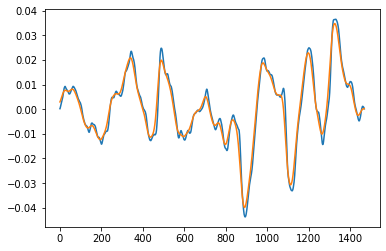

(584, 10, 1)
(439, 10, 1)
(437, 10, 1)
(584, 1)
(439, 1)
(437, 1)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 1)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 10, 64)            128       
_________________________________________________________________
activation_16 (Activation)   (None, 10, 64)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 10, 32)            2080      
_________________________________________________________________
activation_17 (Activation)   (None, 10, 32)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 32)            0         
___________________________________________________________

In [20]:
input_data_length = 10
model_num = 109

short, long, signal = 105, 168, 32
sigma= 10
pull_range = 0
inverse = 0

# print(file_list)
# breakpoint

# dataX, dataY = list(), list()
# for i in range(len(file_list)):

#   if i > 50:
#     break

file = file_list[3]
print(file)
# breakpoint

ohlcv_reg = pd.read_excel(file_path + file, index_col=0)
macd(ohlcv_reg, short=short, long=long, signal=signal)
# plt.plot(ohlcv_reg.iloc[:, [-2]])
# macd(ohlcv_reg, short=150, long=300, signal=50)
# plt.plot(ohlcv_reg.iloc[:, [-2]])
# plt.show()
# breakpoint

ohlcv_reg['realtime_osc_reg'] = np.nan
for i in range(input_data_length, len(ohlcv_reg)):
  y = ohlcv_reg.MACD_OSC.values[i + 1 - input_data_length:i + 1]
  y_smooth = gaussian_filter1d(y, sigma=sigma)

  ohlcv_reg['realtime_osc_reg'].iloc[i] = y_smooth[-1]

ohlcv_reg['osc_reg'] = gaussian_filter1d(ohlcv_reg['MACD_OSC'], sigma=sigma)
ohlcv_reg['osc_reg'] = ohlcv_reg['osc_reg'].shift(-pull_range)
# print(ohlcv_reg.iloc[:, [-3]])
# breakpoint

#     X_data : idl 만큼의 close? (일단),    Y_data : reg
#     실시간으로 reg의 형태가 machine learning으로는 고정되지 않기 때문에,
#     먼저 고정을 시키고, deep learning을 이용해 실시간으로 고정된 regression 결과를 뽑아낼 수 있는지 확인한다.
#     충분히 가능성 있다.     #

#         reg_target = close인 경우 앞의 데이터가 산다.       #  close/ close_reg
if pull_range != 0:
  ohlcv_reg = ohlcv_reg.values[sum(ohlcv_reg.osc_reg.isna())-pull_range:-pull_range, :] # 
else:
  ohlcv_reg = ohlcv_reg.values[sum(ohlcv_reg.osc_reg.isna()):, :] # 

reg_target = ohlcv_reg[:, [-2]].astype(np.float32)
reg_result = ohlcv_reg[:, [-1]].astype(np.float32)
# print(np.sum(np.isnan(reg_target)))
# print(np.sum(np.isnan(reg_result)))
# breakpoint
plt.plot(reg_target)
plt.plot(reg_result)
plt.show()
# breakpoint

# if len(reg_target) == 0:
#   continue

scaler_x = StandardScaler()
scaler_y = StandardScaler()
reg_target = scaler_x.fit_transform(reg_target)
reg_result = scaler_y.fit_transform(reg_result)
# reg_target = max_abs_scaler(reg_target)
# reg_result = max_abs_scaler(reg_result)
# print(reg_target, reg_result)
# plt.plot(reg_target)
# plt.plot(reg_result)
# plt.show()
# breakpoint

dataX, dataY = list(), list()
for i in range(input_data_length, len(reg_target)):

  # group_x = reg_target[i - input_data_length: i]
  group_x = reg_target[i + 1 - input_data_length: i + 1]
  group_y = reg_result[i]
  # print(group_x[0])
  # quit()

  #   데이터 값에 결측치가 존재하는 경우 #
  if sum(sum(np.isnan(group_x))) > 0:
      continue

  if inverse == 1:
      dataX.append(group_x[::-1])  # dataX 리스트에 추가 [::-1]
  else:
      dataX.append(group_x)  # dataX 리스트에 추가 [::-1]
  dataY.append(group_y)

Made_X = np.array(dataX)
Made_Y = np.array(dataY)

# Made_X = np.array(reg_target)
# Made_Y = np.array(reg_result)
# print(Made_X.shape, Made_Y.shape)
# breakpoint  

# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(Made_X, Made_Y, test_size=0.4,
#                                                    shuffle=False)
# X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5,
#                                                    shuffle=False)

#     DATA CONTINOUS SPLIT    #
total_len = len(Made_X)
train_len = int(0.4 * total_len)
val_len = int(0.7 * total_len)

X_train = Made_X[:train_len]
X_val = Made_X[train_len:val_len]
X_test = Made_X[val_len:]
Y_train = Made_Y[:train_len]
Y_val = Made_Y[train_len:val_len]
Y_test = Made_Y[val_len:]
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)
# breakpoint

row = X_train.shape[1]
col = X_train.shape[2]

from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.layers import Dense, LSTM, Dropout, Input, Flatten
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf

class Gelu(Activation):
    def __init__(self, activation, **kwargs):
        super(Gelu, self).__init__(activation, **kwargs)
        self.__name__='gelu'
        
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Gelu(gelu)})


def FER_Model(input_shape=(row, col)):

    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    # net = layers.Dense(128)(visible)
    # # net = layers.LSTM(50, return_sequences=False)(net)
    # net = layers.Activation('gelu')(net)
    # # net = layers.LeakyReLU()(net)
    # net = layers.Dropout(0.3)(net)

    net = layers.Dense(64)(visible)
    # net = layers.LSTM(50, return_sequences=True)(visible)
    net = layers.Activation('gelu')(net)
    # net = layers.LeakyReLU()(net)
    # net = layers.Dropout(0.3)(net)

    
    net = layers.Dense(32)(net)
    # net = layers.LSTM(50, return_sequences=True)(net)
    net = layers.Activation('gelu')(net)
    # net = layers.LeakyReLU()(net)
    net = layers.Dropout(0.3)(net)

  

    # net = layers.Dense(32)(net)
    # # net = layers.LSTM(64, return_sequences=False)(net)
    # net = layers.LeakyReLU()(net)
    # net = layers.Dropout(0.2)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(64)(net)
    net = layers.Activation('gelu')(net)

    net = layers.Dense(1)(net)

    # create model 
    model = Model(inputs =visible, outputs = net)
    # summary layers
    model.summary()

    return model

model = FER_Model()
# from keras.models import load_model
# model = load_model(gdrive_path + 'model/rapid_ascending %s_%s_ohlc.hdf5' % (input_data_length, model_num))

# opt = RMSprop(lr=0.05, rho=0.9,epsilon=1e-10)
opt = Adam(lr=0.001, decay=0.)
# opt = Adadelta(lr=1., rho=0.95, epsilon=1e-13)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])
  
    
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
filepath = gdrive_path + "model/rapid_ascending %s_%s_ohlc.hdf5" % (input_data_length, model_num)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
checkpoint2 = TensorBoard(log_dir='Tensorboard_graph',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
checkpoint3 = EarlyStopping(monitor='val_loss', patience=100)
callbacks_list = [checkpoint, checkpoint2, checkpoint3]

# keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

# we iterate 200 times over the entire training set
num_epochs = 200
history = model.fit(X_train, Y_train,
                    epochs=num_epochs,
                    batch_size=256,
                    validation_data=(X_val, Y_val),
                    verbose=2,
                    callbacks=callbacks_list,
                    shuffle=False,
                    )

#         RESULT COMPARING    #
# pred_reg = model.predict(X_test)
# Y_pred = Made_Y.copy()
# Y_pred[val_len:] = pred_reg

# span_list = list()
# span_list_y = list()
# for i in range(val_len, len(Y_pred)):
#     if Y_pred[i - 1] < Y_pred[i]:
#       span_list.append((i, i + 1))
#     if Made_Y[i - 1] < Made_Y[i]:
#       span_list_y.append((i, i + 1))

# plt.figure(figsize=(10, 7))
# plt.subplot(311)
# if inverse == 1:
#     plt.plot(Made_X[:, [0]].reshape(-1, 1), color='g', label='MACD_OSC') #   if [::-1], [0]
# else:
#     plt.plot(Made_X[:, [-1]].reshape(-1, 1), color='g', label='MACD_OSC')
# plt.plot(Made_Y, color='r', label='Gaussian')
# plt.plot(Y_pred, color='b', label='Gaussian Pred')
# plt.axvline(x=val_len)
# for i in range(len(span_list)):
#     plt.axvspan(span_list[i][0], span_list[i][1], facecolor='y', alpha=0.5)

# plt.title('Gaussian_PRED', color='white')
# plt.legend(loc='upper right')

# plt.subplot(312)
# plt.plot(Y_pred, color='r', label='Gaussian Pred')
# for i in range(len(span_list)):
#     plt.axvspan(span_list[i][0], span_list[i][1], facecolor='y', alpha=0.5)
# plt.xlim(val_len, len(Y_pred))

# plt.subplot(313)
# plt.plot(Made_Y, color='r', label='Gaussian')
# for i in range(len(span_list)):
#     plt.axvspan(span_list[i][0], span_list[i][1], facecolor='y', alpha=0.5)
# for i in range(len(span_list_y)):
#     plt.axvspan(span_list_y[i][0], span_list_y[i][1], facecolor='c', alpha=0.5)
# plt.xlim(val_len, len(Y_pred))

# plt.show()


2019-10-14 TRX ohlcv.xlsx


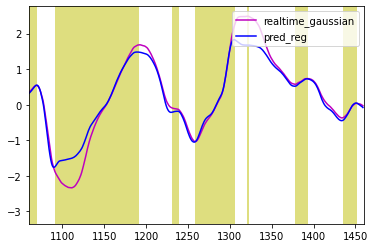

In [22]:
file = file_list[3]
print(file)
inverse = 0

ohlcv_reg = pd.read_excel(file_path + file, index_col=0)
macd(ohlcv_reg, short=short, long=long, signal=signal)

ohlcv_reg['realtime_osc_reg'] = np.nan
for i in range(input_data_length, len(ohlcv_reg)):
  y = ohlcv_reg.MACD_OSC.values[i + 1 - input_data_length:i + 1]
  y_smooth = gaussian_filter1d(y, sigma=sigma)

  ohlcv_reg['realtime_osc_reg'].iloc[i] = y_smooth[-1]
ohlcv_reg['osc_reg'] = gaussian_filter1d(ohlcv_reg['MACD_OSC'], sigma=10)
# print(ohlcv_reg.iloc[:, [-1]])
# breakpoint

#     X_data : idl 만큼의 close? (일단),    Y_data : reg
#     실시간으로 reg의 형태가 machine learning으로는 고정되지 않기 때문에,
#     먼저 고정을 시키고, deep learning을 이용해 실시간으로 고정된 regression 결과를 뽑아낼 수 있는지 확인한다.
#     충분히 가능성 있다.     #

#         reg_target = close인 경우 앞의 데이터가 산다.       #  close/ close_reg
ohlcv_reg = ohlcv_reg.values[sum(ohlcv_reg.osc_reg.isna()):, :]
reg_target = ohlcv_reg[:, [-2]].astype(np.float32)
reg_result = ohlcv_reg[:, [-1]].astype(np.float32)
# print(reg_result)
# print(np.sum(np.isnan(reg_target)))
# print(np.sum(np.isnan(reg_result)))
# breakpoint

scaler_x = StandardScaler()
scaler_y = StandardScaler()
reg_target = scaler_x.fit_transform(reg_target)
reg_result = scaler_y.fit_transform(reg_result)
# reg_target = max_abs_scaler(reg_target)
# reg_result = max_abs_scaler(reg_result)
# print(reg_target, reg_result)
# breakpoint

dataX, dataY = list(), list()
for i in range(input_data_length, len(reg_target)):

  # group_x = reg_target[i - input_data_length: i]
  group_x = reg_target[i + 1 - input_data_length: i + 1]
  # group_x = gaussian_filter1d(reg_target[i + 1 - input_data_length: i + 1], sigma=sigma)
  group_y = reg_result[i]
  # print(group_x[0])
  # quit()

  #   데이터 값에 결측치가 존재하는 경우 #
  if sum(sum(np.isnan(group_x))) > 0:
      continue

  if inverse == 1:
    dataX.append(group_x[::-1])  # dataX 리스트에 추가
  else:
    dataX.append(group_x)
  dataY.append(group_y)

Made_X = np.array(dataX)
Made_Y = np.array(dataY)

# Made_X = np.array(reg_target)
# Made_Y = np.array(reg_result)

# from keras.models import load_model
# model = load_model(gdrive_path + 'model/rapid_ascending %s_%s_ohlc.hdf5' % (input_data_length, model_num))

pred_reg = model.predict(Made_X)

span_list = list()
span_list_y = list()
for i in range(1, len(pred_reg)):
    if pred_reg[i - 1] < pred_reg[i]:
      span_list.append((i, i + 1))
    if Made_Y[i - 1] < Made_Y[i]:
      span_list_y.append((i, i + 1))

plt.subplot(111)
if inverse == 1:
  plt.plot(Made_X[:, [0]].reshape(-1, 1), color='m', label='realtime_gaussian')
else:
  plt.plot(Made_X[:, [-1]].reshape(-1, 1), color='m', label='realtime_gaussian')
  
# plt.plot(Made_Y, color='r', label='real y')
plt.plot(pred_reg, color='b',  label='pred_reg')
plt.legend(loc='upper right')
for i in range(len(span_list)):
    plt.axvspan(span_list[i][0], span_list[i][1], facecolor='y', alpha=0.5)

# plt.subplot(212)
# # if inverse == 1:
# #   plt.plot(Made_X[:, [0]].reshape(-1, 1), color='m', label='MACD_OSC')
# # else:
# #   plt.plot(Made_X[:, [-1]].reshape(-1, 1), color='m', label='MACD_OSC')
# for i in range(len(span_list_y)):
#     plt.axvspan(span_list_y[i][0], span_list_y[i][1], facecolor='c', alpha=0.5)


plt.xlim(len(pred_reg) - 400, len(pred_reg))
plt.show()